# Main Notebook

This notebook contains all the mech interp tools I've developed, centered around doing circuit analysis for any task

## Imports/General Utility Functions

In [1]:
# Requires install of mamba lens
# https://github.com/Phylliida/MambaLens
# pip install git+https://github.com/Phylliida/MambaLens.git
# and also my implementation of ACDC (used for dataset managment)
# pip install git+https://github.com/Phylliida/ACDC.git

In [44]:

import torch
import pandas as pd
import plotly.express as px
import transformer_lens.utils as utils
from mamba_lens import HookedMamba
from acdc.data.utils import generate_dataset
from tqdm import tqdm
from acdc import get_pad_token
from acdc import accuracy_metric
from transformer_lens.hook_points import HookPoint
from functools import partial
from jaxtyping import Float
from IPython.display import clear_output, display
import ipywidgets
from mamba_lens.input_dependent_hooks import clean_hooks
from einops import rearrange


from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    ACDCEvalData,
)

from acdc import ACDCEvalData
from acdc import get_pad_token
from acdc import accuracy_metric

torch.set_grad_enabled(False)

# from transformer lens
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Parse the PyTorch version to check if it's below version 2.0
        major_version = int(torch.__version__.split(".")[0])
        if major_version >= 2:
            return torch.device("mps")

    return torch.device("cpu")

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, height=None, **kwargs):
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if fix_size:
        # default settings aren't very good, these are better
        plot_args = {
            'width': 800,
            'height': 600,
            "autosize": False,
            'showlegend': True,
            'margin': {"l":0,"r":0,"t":100,"b":0}
        }
        if model.cfg.n_layers < len(kwargs['y']):
            plot_args['height'] *= model.cfg.D_conv
        
        if not height is None:
            plot_args['height'] = height
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
    if show:
        fig.show(renderer)
    else:
        return fig

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
    fig.show()

def get_batched_index_into(indices):
    '''
    given data that is [B,N,V] and indicies that are [B,N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    first_axis = []
    second_axis = []
    third_axis = []
    B, _, _ = indices.size()
    for b in range(B):
        second, third = get_index_into(indices[b])
        first_axis.append(torch.full(second.size(), fill_value=b, device=model.cfg.device))
        second_axis.append(second)
        third_axis.append(third)

    return torch.cat(first_axis), torch.cat(second_axis), torch.cat(third_axis)

def get_index_into(indices):
    '''
    given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
    this gives you indexes you can use to access your values
    '''
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()
    second_axis_index = indices.flatten()
    return first_axis_index, second_axis_index

## Load Model

In [3]:

torch.set_grad_enabled(False)
device = get_device()
print("device", device)
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device=device)

device cuda


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Setup Data

In [110]:
def decode_and_encode(tokenizer, tokens):
    '''
    Gets rid of weird encoding issues by encoding and decoding
    The tokens will be different that's okay and intentional
    '''
    prompt = tokenizer.decode(tokens).encode("ascii", "ignore").decode("ascii", "ignore")
    return tokenizer.encode(prompt)

def copy_data_generator(tokenizer, num_patching_pairs, copy_seq_len, num_repeats):
    '''
    Generates copy_seq_len random tokens, repeated twice (with the last token cut off)
    This is just a test to see if it can copy the repeated sequence from before

    for example, 

    uncorrupted:
    a b c d a b c (answer is d)
    corrupted:
    a b c e a b c (answer is e)
    '''
    first_len = None

    # ignore special tokens like BOS or PAD
    special_token_ids = set()
    for special_token_name, token_str in model.tokenizer.special_tokens_map.items():
        special_token_ids.add(model.tokenizer.convert_tokens_to_ids([token_str])[0])
    valid_ids = []
    for tok in range(tokenizer.vocab_size):
        if not tok in special_token_ids:
            valid_ids.append(tok)    
    valid_ids = torch.tensor(valid_ids)
    for i in list(range(num_patching_pairs)):
        while True:
            # sample without replacement
            # one extra so corrupted isn't in sequence
            data = valid_ids[torch.randperm(len(valid_ids))[:copy_seq_len+1]].flatten()
            corrupted_id = data[-1]
            data_repeating = data[:-1]
            uncorrupted_data = torch.concatenate([data_repeating]*num_repeats + [data_repeating[:-1]])
            corrupted_data = torch.concatenate([data_repeating[:-1], torch.tensor([corrupted_id])]*num_repeats + [data_repeating[:-1]])
            # make sure it encodes and decodes properly
            uncorrupted_prompt = tokenizer.decode(uncorrupted_data).encode("ascii", "ignore").decode("ascii", "ignore")
            corrupted_prompt = tokenizer.decode(corrupted_data).encode("ascii", "ignore").decode("ascii", "ignore")
            uncorrupted_answer = tokenizer.decode(data_repeating[-1]).encode("ascii", "ignore").decode("ascii", "ignore")
            corrupted_answer = tokenizer.decode(torch.tensor([corrupted_id])).encode("ascii", "ignore").decode("ascii", "ignore")
            reencoded_uncorrupted_data = torch.tensor(tokenizer.encode(uncorrupted_prompt))
            reencoded_corrupted_data = torch.tensor(tokenizer.encode(corrupted_prompt))
            if reencoded_uncorrupted_data.size() == uncorrupted_data.size() and reencoded_corrupted_data.size() == corrupted_data.size() and torch.all(reencoded_uncorrupted_data == uncorrupted_data) and torch.all(reencoded_corrupted_data == corrupted_data):
                break
        yield uncorrupted_prompt, [uncorrupted_answer], [corrupted_answer]
        yield corrupted_prompt, [corrupted_answer], [uncorrupted_answer]

num_patching_pairs = 200
seed = 51
valid_seed = 51
constrain_to_answers = False
has_symmetric_patching = True
varying_data_lengths = False
copy_seq_len = 6
num_repeats = 2 # just immediately copying seems only somewhat doable by this model

data = generate_dataset(model=model,
              data_generator=copy_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=varying_data_lengths,
              copy_seq_len=copy_seq_len,
              num_repeats=num_repeats)

for i in list(range(10)):
    uncorrupted_i = i*2
    corrupted_i = i*2+1
    uncorrupted = data.data[uncorrupted_i][:data.last_token_position[uncorrupted_i]+1]
    corrupted = data.data[corrupted_i][:data.last_token_position[corrupted_i]+1]
    print(i)
    print(model.to_str_tokens(uncorrupted))
    print(f"answers   are {model.to_str_tokens(data.correct[uncorrupted_i])}")
    print(f"incorrect are {model.to_str_tokens(data.incorrect[uncorrupted_i])}")
    print(model.to_str_tokens(corrupted))
    print(f"answers   are {model.to_str_tokens(data.correct[corrupted_i])}")
    print(f"incorrect are {model.to_str_tokens(data.incorrect[corrupted_i])}")

0
['<|endoftext|>', ' Electron', 'rising', ' inaccur', ' invisible', ',...,', ' proteins', ' Electron', 'rising', ' inaccur', ' invisible', ',...,', ' proteins', ' Electron', 'rising', ' inaccur', ' invisible', ',...,']
answers   are [' proteins']
incorrect are [' Love']
['<|endoftext|>', ' Electron', 'rising', ' inaccur', ' invisible', ',...,', ' Love', ' Electron', 'rising', ' inaccur', ' invisible', ',...,', ' Love', ' Electron', 'rising', ' inaccur', ' invisible', ',...,']
answers   are [' Love']
incorrect are [' proteins']
1
['<|endoftext|>', ' appreciation', ' swarm', ' uncertainties', ' register', ' 1985', ' persists', ' appreciation', ' swarm', ' uncertainties', ' register', ' 1985', ' persists', ' appreciation', ' swarm', ' uncertainties', ' register', ' 1985']
answers   are [' persists']
incorrect are ['633']
['<|endoftext|>', ' appreciation', ' swarm', ' uncertainties', ' register', ' 1985', '633', ' appreciation', ' swarm', ' uncertainties', ' register', ' 1985', '633', ' a

## Eval Data

In [111]:

print("printing example data points:")
for b in range(4):
    pad_token = get_pad_token(model.tokenizer)
    # because there is padding if lengths vary, this only fetches the tokens that are part of the sequence
    toks = data.data[b][:data.last_token_position[b]+1]
    print(model.tokenizer.decode(toks))
    for ind, tok in enumerate(data.correct[b]):
        if tok != pad_token:
            print(f"  correct answer: {repr(model.tokenizer.decode([tok.item()]))}")
    for ind, tok in enumerate(data.incorrect[b]):
        if tok != pad_token:
            print(f"  incorrect answer: {repr(model.tokenizer.decode([tok.item()]))}")

TOP_K = 5
def logging_incorrect_metric(data: ACDCEvalData):
    pad_token = get_pad_token(model.tokenizer)
    for data_subset in [data.patched, data.corrupted]:
        batch, _ = data_subset.data.size()
        for b in range(batch):
            if not data_subset.top_is_correct[b].item():
                if not data.constrain_to_answers:
                    logits = data_subset.logits[b]
                    prs = torch.nn.functional.softmax(logits, dim=0)
                    top = torch.argsort(-logits)
                toks = data_subset.data[b][:data_subset.last_token_position[b]+1]
                print("failed on this data point:")
                print(model.to_str_tokens(toks))
                print("correct prs:")
                for i, tok in enumerate(data_subset.correct[b]):
                    if tok.item() != pad_token:
                        print(data_subset.correct_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                        if not data.constrain_to_answers:
                            top_k_pos = (top==tok.item()).nonzero().item()
                            print(f" top k pos of {top_k_pos}")
                print("incorrect prs:")
                for i, tok in enumerate(data_subset.incorrect[b]):
                    if tok.item() != pad_token:
                        print(data_subset.incorrect_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                        if not data.constrain_to_answers:
                            top_k_pos = (top==tok.item()).nonzero().item()
                            print(f" top k pos of {top_k_pos}")
                if not data.constrain_to_answers:
                    for i, tok in enumerate(top[:TOP_K]):
                        if tok.item() in [x.item() for x in data_subset.correct[b]]:
                            print(f"  correct   top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                        elif tok.item() in [x.item() for x in data_subset.incorrect[b]]:
                            print(f"  incorrect top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                        else:
                            print(f"  other     top {i} token {tok} = {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
    return data.patched.correct_prs[:,0]

pr_correct = data.eval(model=model, batch_size=10, metric=logging_incorrect_metric)
print(pr_correct)
print(torch.mean(pr_correct))
accuracy = data.eval(model=model, batch_size=10, metric=accuracy_metric)
print(accuracy)
print(torch.mean(accuracy))

printing example data points:
<|endoftext|> Electronrising inaccur invisible,..., proteins Electronrising inaccur invisible,..., proteins Electronrising inaccur invisible,...,
  correct answer: ' proteins'
  incorrect answer: ' Love'
<|endoftext|> Electronrising inaccur invisible,..., Love Electronrising inaccur invisible,..., Love Electronrising inaccur invisible,...,
  correct answer: ' Love'
  incorrect answer: ' proteins'
<|endoftext|> appreciation swarm uncertainties register 1985 persists appreciation swarm uncertainties register 1985 persists appreciation swarm uncertainties register 1985
  correct answer: ' persists'
  incorrect answer: '633'
<|endoftext|> appreciation swarm uncertainties register 1985633 appreciation swarm uncertainties register 1985633 appreciation swarm uncertainties register 1985
  correct answer: '633'
  incorrect answer: ' persists'
failed on this data point:
['<|endoftext|>', ' limbs', ' wholesale', ' pedig', 'ocular', ' aroma', 'Sportspeople', ' limbs',

# Grid Search for hparams of dataset to get good enough accuracy that we have some leeway for circuit analysis (also, is it sensitive? Seems no)

In [ ]:

num_patching_pairs = 100
seed = 42
valid_seed = 41
constrain_to_answers = False
has_symmetric_patching = True
varying_data_lengths = False

max_seq_len = 40
max_num_repeats = 10

output_data = torch.zeros([max_seq_len-1, max_num_repeats-1])
for i, copy_seq_len in enumerate(range(1,max_seq_len)):
    print(copy_seq_len)
    for j, num_repeats in enumerate(tqdm(range(1,max_num_repeats))):
        seed = i+j*num_repeats
        data = generate_dataset(model=model,
                    data_generator=copy_data_generator,
                    num_patching_pairs=num_patching_pairs,
                    seed=seed,
                    valid_seed=valid_seed,
                    constrain_to_answers=constrain_to_answers,
                    has_symmetric_patching=has_symmetric_patching, 
                    varying_data_lengths=varying_data_lengths,
                    copy_seq_len=copy_seq_len,
                    num_repeats=num_repeats)
        output_data[i,j] = torch.mean(data.eval(model=model, batch_size=20, metric=accuracy_metric)).item()


1


100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


2


100%|██████████| 9/9 [00:35<00:00,  3.99s/it]


3


100%|██████████| 9/9 [00:41<00:00,  4.62s/it]


4


100%|██████████| 9/9 [00:46<00:00,  5.13s/it]


5


100%|██████████| 9/9 [00:58<00:00,  6.53s/it]


6


100%|██████████| 9/9 [01:05<00:00,  7.25s/it]


7


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


8


100%|██████████| 9/9 [01:20<00:00,  8.96s/it]


9


100%|██████████| 9/9 [01:32<00:00, 10.27s/it]


10


100%|██████████| 9/9 [01:39<00:00, 11.04s/it]


11


100%|██████████| 9/9 [01:46<00:00, 11.86s/it]


12


100%|██████████| 9/9 [02:03<00:00, 13.71s/it]


13


100%|██████████| 9/9 [02:18<00:00, 15.42s/it]


14


100%|██████████| 9/9 [02:22<00:00, 15.86s/it]


15


100%|██████████| 9/9 [02:40<00:00, 17.80s/it]


16


100%|██████████| 9/9 [02:50<00:00, 18.91s/it]


17


100%|██████████| 9/9 [02:14<00:00, 15.00s/it]


18


100%|██████████| 9/9 [01:55<00:00, 12.78s/it]


19


100%|██████████| 9/9 [02:03<00:00, 13.69s/it]


20


100%|██████████| 9/9 [02:12<00:00, 14.70s/it]


21


100%|██████████| 9/9 [02:19<00:00, 15.53s/it]


22


100%|██████████| 9/9 [02:27<00:00, 16.35s/it]


23


100%|██████████| 9/9 [02:35<00:00, 17.28s/it]


24


100%|██████████| 9/9 [02:47<00:00, 18.62s/it]


25


100%|██████████| 9/9 [02:57<00:00, 19.69s/it]


26


100%|██████████| 9/9 [03:06<00:00, 20.69s/it]


27


100%|██████████| 9/9 [03:16<00:00, 21.83s/it]


28


100%|██████████| 9/9 [03:20<00:00, 22.26s/it]


29


100%|██████████| 9/9 [03:36<00:00, 24.07s/it]


30


100%|██████████| 9/9 [03:44<00:00, 24.97s/it]


31


100%|██████████| 9/9 [03:59<00:00, 26.57s/it]


32


100%|██████████| 9/9 [04:15<00:00, 28.38s/it]


33


100%|██████████| 9/9 [04:29<00:00, 29.94s/it]


34


100%|██████████| 9/9 [04:50<00:00, 32.30s/it]


35


100%|██████████| 9/9 [05:13<00:00, 34.80s/it]


36


100%|██████████| 9/9 [05:35<00:00, 37.25s/it]


37


100%|██████████| 9/9 [05:55<00:00, 39.51s/it]


38


100%|██████████| 9/9 [06:04<00:00, 40.47s/it]


39


100%|██████████| 9/9 [06:30<00:00, 43.34s/it]


In [ ]:
imshow(output_data.T, x=[str(x) for x in range(1,max_seq_len)], y=[str(y) for y in range(1,max_num_repeats)], fix_size=True, font_size=9, title='accuracy of mamba-370m on copy task', xaxis='num tokens in sequence', yaxis='num times repeated')

# here we see that it is very good as long as sequence longer than 3 and it's repeated at least twice. It's alright for repeated once but I'd prefer starting with a higher accuracy.
# I'll do 6 tokens in sequence, and repeat it 2 times (so 3 times total)
# 1 hr 5 min

## Patching

In [27]:
prompt_uncorrupted = model.tokenizer.decode(data.data[0][1:])
prompt_corrupted = model.tokenizer.decode(data.data[1][1:])
uncorrupted_answer = model.tokenizer.decode(data.correct[0])
corrupted_answer = model.tokenizer.decode(data.correct[1])

print(prompt_uncorrupted)
print(prompt_corrupted)
print(uncorrupted_answer)
print(corrupted_answer)

 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity
 jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity
118
 oxygen


In [30]:
# modified from neel nanda's examples

H_N_PATCHING_LAYER = 39

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

# you can modify this to only run things on a subset of layers
limited_layers = list(range(model.cfg.n_layers))


answer_tokens = sorted(list(set([model.tokenizer.encode(uncorrupted_answer)[0], model.tokenizer.encode(corrupted_answer)[0]])))

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]



# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)


# [B,L,V]
uncorrupted_logits = model.run_with_hooks(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff



# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type,
                 patching_hook_name_func,
                 patching_hook_func,
                 batch_size,
                 show_options, 
                 min_logit_diff,
                 max_logit_diff,
                 min_pr_diff,
                 max_pr_diff,
                 token_labels,
                 prompt_uncorrupted_tokens,
                 uncorrupted_answer,
                 corrupted_answer,
                 always_hooks=None,
                 show_plot=True,
                 **kwargs):
    _, L = prompt_uncorrupted_tokens.size()
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)

    num_results = n_layers
    if patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    patching_result_normalized_logits = torch.zeros((num_results, L), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_results, L), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    
    hooks = []
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters works via initializing things, then storing all the stuff we want to hook, then doing all that in place at the same time
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            # reset the storage to empty/initialize stuff
            hooks.append((f'blocks.{layer}.hook_layer_input', better_conv_patching_init_hook))
            # doing all the patches we have stored (below) at the same time
            hooks.append((f'blocks.{layer}.hook_conv', partial(better_conv_patching_hook, input_hook_name=f'blocks.{layer}.hook_in_proj', layer=layer)))

    if not always_hooks is None:
        hooks += always_hooks

    initial_num_hooks = len(hooks)

    
    if patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch)
                batch += 1
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in list(enumerate(limited_layers)):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this -d_conv-1 filter is always zero for some reason
                for position in range(L):
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                    hooks.append((f'blocks.{layer}.hook_in_proj', partial(better_conv_patching_storage_hook, position=position, layer=layer, conv_filter_i=conv_filter_i, batch=batch)))
                    #patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch, conv_filter_i=conv_filter_i)
                    batch += 1
                    indices.append((ind,position))
                    #hooks.append((patching_hook_name, patching_hook))
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in list(enumerate(limited_layers)):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch)
                batch += 1
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))

    
    if batch_size != BATCH_SIZE_ALL:
        V = model.cfg.V
        patched_logits = torch.zeros([len(indices), L, V])
        for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
            batch_end = min(len(indices), batch_start+int(batch_size))
            # always do the initial they are for storage
            batch_hooks = hooks[:initial_num_hooks] + hooks[initial_num_hooks+batch_start:initial_num_hooks+batch_end]
            cur_batch_size = batch_end-batch_start
            patched_logits[batch_start:batch_end] = model.run_with_hooks(prompt_uncorrupted_tokens.expand(cur_batch_size,L), fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
    else:
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens.expand(batch,L), fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
   
    # [B,L,V]
    patched_prs = torch.softmax(patched_logits, dim=2)
    print("finished patching, plotting...")
    for b, (i,position) in enumerate(indices):
        if corrupted_answer != uncorrupted_answer:
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            normalized_patched_logit_diff = normalized_patched_logit_diff #normalized_always_logit_diff - normalized_patched_logit_diff
            patching_result_normalized_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            normalized_patched_pr_diff = normalized_always_pr_diff - normalized_patched_pr_diff
            patching_result_normalized_prs[i, position] = normalized_patched_pr_diff

        for k, answer_token in enumerate(answer_tokens):
            patching_result_logits[i, position, k] = patched_logits[b,-1,answer_token]
            patching_result_prs[i, position, k] = patched_prs[b,-1,answer_token]
    
        
    if patching_type == H_N_PATCHING:
        layer_labels = [str(n) for n in range(N)]
    elif patching_type == CONV_FILTERS_PATCHING:
        layer_labels = []
        for layer in limited_layers:
            for conv_i in range(1, D_conv):
                layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
    else:
        layer_labels = [str(layer) for layer in limited_layers]
    figs = []
    y_axis = 'Layer'
    if patching_type == H_N_PATCHING:
        y_axis = 'N'
    if show_plot:
        if corrupted_answer != uncorrupted_answer:
            if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                figs.append(imshow(patching_result_normalized_logits, x=token_labels, y=layer_labels, xaxis="Position", yaxis=y_axis, title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8, show=False))
            if show_options in [SHOW_PR, SHOW_BOTH]:
                figs.append(imshow(patching_result_normalized_prs, x=token_labels, y=layer_labels, xaxis="Position", yaxis=y_axis, title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8, show=False))
        
        for k, answer_token in enumerate(answer_tokens):
            if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                figs.append(imshow(patching_result_logits[:,:,k], color_continuous_midpoint=None, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8, show=False))
            if show_options in [SHOW_PR, SHOW_BOTH]:
                figs.append(imshow(patching_result_prs[:,:,k], x=token_labels, y=layer_labels, xaxis="Position", yaxis=y_axis, title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8, show=False)) 
        
        for fig in figs:
            plot_args_copy = dict(list(plot_args.items()))
            if patching_type == CONV_FILTERS_PATCHING:
                plot_args_copy['height'] *= D_conv
            fig.update_layout(**plot_args_copy)
            fig.update_layout(legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ))
            fig.show()
    else:
        return layer_labels, y_axis, patching_result_normalized_logits, patching_result_normalized_prs, patching_result_logits, patching_result_prs

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global progress # it's slow enough that progress bar is useful
    if layer == 0:
        progress = tqdm(total=len(limited_layers))
    else:
        progress.update(1)
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    conv_input_corrupted = rearrange(corrupted_activations[f'blocks.{layer}.hook_in_proj'], 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [1,E,L]                                   [E,1]                          # [1,E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_corrupted[:,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[0,:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output


# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
global storage
global conv_storage
storage = {}
conv_storage = {}
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def better_conv_patching_init_hook(
    x,
    hook: HookPoint,
    **kwargs
):
    #print("init hook with layer", hook.name)
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    global storage
    storage = {}
    conv_storage = {CONV_BATCHES: set()}
    return x

def better_conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch: int,
    **kwargs,
):
    #print("append hook with layer", hook.name, "conv filter", conv_filter_i, "position", position, "layer", layer, "batch", batch)
    batch_start = batch
    batch_end = batch+1
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange
global corrupted_activations

global conv_storage
def better_conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters
    
    D_CONV = model.cfg.d_conv

    global corrupted_activations
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end]
            conv_input_corrupted = corrupted_activations[input_hook_name]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]
           




## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_x = corrupted_activations[hook.name]
    x[batch, position, :] = corrupted_x[0, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch] = corrupted_h[0]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch,:,n] = corrupted_h[0,:,n]
    return h




def generate_always_hooks():
    hooks = []

    LAYER = 39
    _, L = prompt_uncorrupted_tokens.size()
    #for pos in range(L):
        # slice(None, None) is same as : (which means all)
        #hooks.append((f'blocks.{LAYER}.hook_h.{pos}', partial(h_patching_hook, layer=LAYER, position=pos, batch=slice(None, None))))
    #    hooks.append((f'blocks.{LAYER}.hook_layer_input', partial(position_patching_hook, layer=LAYER, position=pos, batch=slice(None, None))))

    #ABLATE_POS = 3
    #hooks.append((f'blocks.{35}.hook_layer_input', partial(position_patching_hook, layer=LAYER, position=3, batch=slice(None, None))))
    #hooks.append((f'blocks.{40}.hook_layer_input', partial(position_patching_hook, layer=LAYER, position=3, batch=slice(None, None))))
    #FINAL_POS = 19
    #hooks.append((f'blocks.{47}.hook_layer_input', partial(position_patching_hook, layer=LAYER, position=FINAL_POS, batch=slice(None, None))))
    return hooks
always_hooks = generate_always_hooks()

always_logits = model.run_with_hooks(prompt_uncorrupted_tokens, fwd_hooks=always_hooks, only_use_these_layers=limited_layers, fast_ssm=False, fast_conv=False)


always_prs = torch.softmax(always_logits, dim=2)
always_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=always_logits,
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
# normalize it so
# 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
# 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
normalized_always_logit_diff = (always_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
# now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
# so now
# 0 means that it is acting like the uncorrupted model
# 1 means that it is acting like the corrupted model
normalized_always_logit_diff = 1.0 - normalized_always_logit_diff

# same for pr
always_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=always_prs,
                                                    uncorrupted_answer=uncorrupted_answer,
                                                    corrupted_answer=corrupted_answer)
normalized_always_pr_diff = 1.0-(always_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)




SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'

patching_types = {
    'resid pre': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_layer_input', position_patching_hook),
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='patching type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)



def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     show_plot=show_plot,
                     min_logit_diff=min_logit_diff,
                     max_logit_diff=max_logit_diff,
                     min_pr_diff=min_pr_diff,
                     max_pr_diff=max_pr_diff,
                     token_labels=token_labels,
                     prompt_uncorrupted_tokens=prompt_uncorrupted_tokens,
                     uncorrupted_answer=uncorrupted_answer,
                     corrupted_answer=corrupted_answer,
                     always_hooks=generate_always_hooks())

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

uncorrupted prompt
 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity
'118' logit 9.80660343170166
'118' pr 0.8549307584762573
' oxygen' logit -5.07356071472168
' oxygen' pr 2.948205803932069e-07

corrupted prompt
 jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity
'118' logit -26.385570526123047
'118' pr 6.05661831798443e-09
' oxygen' logit -7.486489295959473
' oxygen' pr 0.9772311449050903


Dropdown(description='patching type', options=('resid pre', 'layer input', 'normalized input', 'skip', 'in pro…

Dropdown(description='batch size', options=('all', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11…

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

# Average Patchings over multiple data points

In [29]:

prompt_uncorrupted = "".join(model.tokenizer.decode(data.data[0][1:]))
prompt_corrupted = "".join(model.tokenizer.decode(data.data[1][1:]))
# note the spaces are important due to tokenization
uncorrupted_answer = "".join(model.tokenizer.decode([data.correct[0][0]]))
corrupted_answer = "".join(model.tokenizer.decode([data.correct[1][0]]))

print(prompt_uncorrupted)
print(prompt_corrupted)
print(uncorrupted_answer)
print(corrupted_answer)

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='patching type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['False', 'True']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)
H_N_PATCHING_LAYER = 39


global corrupted_activations

def do_patching(arg, show_plot=True):
    patching_result_normalized_logits_total = None
    with output:
        clear_output()
        iters = 0
        for i in range(data.data.size()[0]//2):
            uncorrupted_i = i*2
            corrupted_i = i*2+1
            uncorrupted = data.data[uncorrupted_i]
            corrupted = data.data[corrupted_i]
    
            uncorrupted_answer = model.tokenizer.decode([data.correct[uncorrupted_i][0]])
            corrupted_answer = model.tokenizer.decode([data.correct[corrupted_i][0]])
            answer_tokens = sorted(list(set([model.tokenizer.encode(uncorrupted_answer)[0], model.tokenizer.encode(corrupted_answer)[0]])))
        
            prompt_uncorrupted_tokens = uncorrupted[:data.last_token_position[uncorrupted_i]+1].view(1,-1)
            prompt_corrupted_tokens = corrupted[:data.last_token_position[corrupted_i]+1].view(1,-1)

            #print(model.to_str_tokens(prompt_uncorrupted_tokens))
            #print(model.to_str_tokens(prompt_corrupted_tokens))
            #print("answers")
            #print(uncorrupted_answer, corrupted_answer)
            # [B,L,V]
            global corrupted_activations
            corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
            corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
            corrupted_prs = torch.softmax(corrupted_logits, dim=2)
            corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
            
            # [B,L,V]
            uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
            uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
            uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
            uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
            
            uncorrupted_index = model.to_single_token(uncorrupted_answer)
            corrupted_index = model.to_single_token(corrupted_answer)
            
            # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
            L = len(prompt_uncorrupted_tokens[0])
            if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
                raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus
        
            # diff is logit of uncorrupted_answer - logit of corrupted_answer
            # we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
            # we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
            # thus we can treat these as (rough) min and max possible values
            min_logit_diff = corrupted_logit_diff
            max_logit_diff = uncorrupted_logit_diff
            
            min_pr_diff = corrupted_pr_diff
            max_pr_diff = uncorrupted_pr_diff
            
            # make token labels that describe the patch
            corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
            uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
            token_labels = []
            for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
                if corrupted_token == uncorrupted_token:
                    token_labels.append(f"{corrupted_token}_{index}")
                else:
                    token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")
        
                
            print(i, "/", data.data.size()[0]//2)
            patching_type = choose_patching_type.patching_type
            hook_name_func, hook_func = patching_types[patching_type]
            layer_labels, y_axis, patching_result_normalized_logits, patching_result_normalized_prs, patching_result_logits, patching_result_prs = run_patching(
                         patching_type=patching_type,
                         patching_hook_name_func=hook_name_func,
                         patching_hook_func=hook_func,
                         batch_size=choose_batch_size.batch_size,
                         fast_ssm=choose_fast_ssm.fast_ssm,
                         fast_conv=choose_fast_conv.fast_conv,
                         show_options=choose_show_options.show_options,
                         show_plot=False,
                         min_logit_diff=min_logit_diff,
                         max_logit_diff=max_logit_diff,
                         min_pr_diff=min_pr_diff,
                         max_pr_diff=max_pr_diff,
                         token_labels=token_labels,
                         prompt_uncorrupted_tokens=prompt_uncorrupted_tokens.view(1,-1),
                         uncorrupted_answer=uncorrupted_answer,
                         corrupted_answer=corrupted_answer)
            iters += 1
            if patching_result_normalized_logits_total is None:
                patching_result_normalized_logits_total = patching_result_normalized_logits
            else:
                patching_result_normalized_logits_total += patching_result_normalized_logits
        fig = imshow(patching_result_normalized_logits_total/iters, x=token_labels, y=layer_labels, xaxis="Position", yaxis=y_axis, title=f"Normalized logit difference after patching {patching_type} using hook {hook_name_func(layer='{layer}', position='{position}')}", font_size=8, show=False)
        plot_args_copy = dict(list(plot_args.items()))
        # this code can be used to make it taller so its more readable, if u plot them all
        if patching_type == CONV_FILTERS_PATCHING:
            plot_args_copy['height'] *= model.cfg.d_conv
        
        fig.update_layout(**plot_args_copy)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
        fig.show()
        if patching_type == CONV_FILTERS_PATCHING: # also plot just layer 39
            layer_labels = [(i, label) for (i, label) in enumerate(layer_labels) if '39' in label]
            patching_result_normalized_logits_total = patching_result_normalized_logits_total[torch.tensor([i for (i, label) in layer_labels])]
            layer_labels = [label for (i,label) in layer_labels]
            plot_args_copy = dict(list(plot_args.items()))
            fig = imshow(patching_result_normalized_logits_total/iters, x=token_labels, y=layer_labels, xaxis="Position", yaxis=y_axis, title=f"Normalized logit difference after patching {patching_type} using hook {hook_name_func(layer='{layer}', position='{position}')}", font_size=8, show=False)
    
            fig.update_layout(**plot_args_copy)
            fig.update_layout(legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ))
            fig.show()
        

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)
    
# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity118 jew humGuy not variation LT erredCapacity
 jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity oxygen jew humGuy not variation LT erredCapacity
118
 oxygen


Dropdown(description='patching type', options=('resid pre', 'layer input', 'normalized input', 'skip', 'in pro…

Dropdown(description='batch size', options=('all', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11…

Dropdown(description='fast conv', options=('False', 'True'), value='False')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

# Positional EAP with integrated gradients

In [112]:
# REMEMBER TO MANUALLY PATCH TL LENS TO HAVE register_full_backward_hook

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}
BATCH_SIZE = 10

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched
# 3. just subtract the outputs in the same forward pass, instead of a cached "unpatched" run
#  we do 3

global alpha
alpha = 1

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha

def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B, L]
    attr = (grad*upstream_diffs).sum(dim=-1)
    # [B, N_upstream, L]           [N_upstream, B, L]
    attr         =   torch.transpose(attr, 0, 1)
    # [B, N_upstream, L]
    attr = attr.clone().detach()
    if POSITIONS:
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr
    else:
        #[B, N_upstream]
        attr = attr.sum(dim=-1)
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr



def cache_conv_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"]):
    cached_conv_inputs.append(conv_input)
    return conv_input

# for each conv slice,
# we have 
global filter_terms
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    corrupted_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    slice_terms : [],
) -> Float[torch.Tensor, "B L E"]:
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual slices

    # we have two input hooks, the second one is the one we want
    D_CONV = model.cfg.d_conv

    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    uncorrupted_input = rearrange(cached_conv_inputs[layer], 'B L E -> B E L')
    corrupted_input = rearrange(corrupted_conv_inputs[layer], 'B L E -> B E L')
    B,E,L = uncorrupted_input.size()
    uncorrupted_input = torch.nn.functional.pad(uncorrupted_input, (D_CONV-1,0), mode='constant', value=0)
    corrupted_input = torch.nn.functional.pad(corrupted_input, (D_CONV-1,0), mode='constant', value=0)
    #print(uncorrupted_input.size(), corrupted_input.size())
    # we want some "patch hook" thing that uses autodiff or somethin
    output = torch.zeros([B,E,L], device=model.cfg.device)
    global alpha
    layer_slices = []
    for i in range(D_CONV):
        # [B,E,L]                      [E,1]                      [B,E,L]
        uncorrupted_contribution = conv_weight[:,0,i].view(E,1)*uncorrupted_input[:,:,i:i+L]
        corrupted_contribution = conv_weight[:,0,i].view(E,1)*corrupted_input[:,:,i:i+L]
        slice_term = uncorrupted_contribution*(1-alpha)+corrupted_contribution*(alpha)
        diff = -uncorrupted_contribution+corrupted_contribution
        slice_term.retain_grad()
        #slice_term.requires_grad = True
        layer_slices.append((diff, slice_term))
        output += slice_term
    output = rearrange(output, 'B E L -> B L E')
    output += conv_bias
    slice_terms.append(layer_slices)
    return output

def bwd_conv_hook(
    grad : Float[torch.Tensor, "B L E"], # we don't use this, hook is just so we are present in backward pass
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    corrupted_conv_inputs : Float[torch.Tensor, "NLayers B L E"],
    slice_terms: list # one list for each layer, each list contains one tensor for each conv slice
):
    # [B, L, E]
    #diffs = (-cached_conv_inputs[layer]+corrupted_conv_inputs[layer])
    layer_slice_terms = slice_terms[layer]
    for slice_i, (diff, slice_term) in enumerate(layer_slice_terms):
        # [B,E,L]
        slice_grad = slice_term.grad
        # dot product over the E dimension
        # [B,L]         [B,E,L]   [B,E,L]
        slice_attr = (slice_grad * diff).sum(dim=-2) # sum over E dimension
        if POSITIONS:
            # [B,L]
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr 
        else:
            #[B]
            slice_attr = slice_attr.sum(dim=-1)
            conv_attributions[batch_start:batch_end,layer,slice_i] += slice_attr

B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2
D_CONV = model.cfg.d_conv

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
POSITIONS = True
if POSITIONS:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2, L], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV, L], device=model.cfg.device)
else:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)
    conv_attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers, D_CONV], device=model.cfg.device)



input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]
conv_input_names = [f'blocks.{i}.hook_in_proj' for i in range(model.cfg.n_layers)]
conv_names = [f'blocks.{i}.hook_conv' for i in range(model.cfg.n_layers)]

for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'

    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=[embed_name] + output_names + conv_input_names, **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=[embed_name] + output_names + conv_input_names, **model_kwargs)
    
    batch_size,L,D = unpatched_layer_outputs[output_names[0]].size()
    _,_,E = unpatched_layer_outputs[conv_input_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    # backward pass to compute grad of diff
    torch.set_grad_enabled(True)
        
    corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    corrupted_conv_inputs = torch.zeros([model.cfg.n_layers,batch_size,L,E], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]
        corrupted_conv_inputs[layer] = corrupted_layer_outputs[conv_input_names[layer]]    
    # cleanup
    del corrupted_layer_outputs
    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    
    # EAP layer hooks
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                                   layer=-1,
                                   cached_outputs=cached_outputs))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                                    layer=layer,
                                    cached_outputs=cached_outputs)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                      cached_outputs=cached_outputs,
                      corrupted_outputs=corrupted_outputs,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          cached_outputs=cached_outputs,
                          corrupted_outputs=corrupted_outputs,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    # Conv hooks
    cached_conv_inputs = []
    slice_terms = []

    fwd_hooks += [(conv_input_names[layer],
                  partial(
                      cache_conv_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                  )) for layer in range(model.cfg.n_layers)]
    
    
    fwd_hooks += [(conv_names[layer],
                  partial(
                      conv_patching_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                      corrupted_conv_inputs=corrupted_conv_inputs,
                      slice_terms=slice_terms,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks += [(input_names[layer], # anywhere before the slice terms works, so we'll just pick start of layer since that backward is called
                  partial(
                      bwd_conv_hook,
                      layer=layer,
                      cached_conv_inputs=cached_conv_inputs,
                      corrupted_conv_inputs=corrupted_conv_inputs,
                      slice_terms=slice_terms,
                      batch_start=batch_start,
                      batch_end=batch_end,
                  )) for layer in range(model.cfg.n_layers)]
    
    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS+1):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        slice_terms.clear()
        cached_conv_inputs.clear()
        torch.cuda.empty_cache()
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        corrupted_outputs.grad = None
        corrupted_outputs.detach_()
        #cached_conv_inputs.grad = None
        #cached_conv_inputs.detach_()
        corrupted_conv_inputs.grad = None
        corrupted_conv_inputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        if i == ITERS:
            torch.cuda.empty_cache()
            break # we just use this for cleaning up
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0]
        )
        print(f"alpha {alpha} metric {metric}")
        # run backward pass, which adds to attributions
        metric.backward()
        #conv_attrs = conv_attributions.mean(dim=0)
        #print(conv_attrs)
        #attrs = attributions.mean(dim=0)
        #print(attrs)

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS
conv_attributions[:] = conv_attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)

0 10
alpha 0.0 metric 0.9999998211860657
alpha 0.25 metric 0.12480664253234863
alpha 0.5 metric 0.00946663599461317
alpha 0.75 metric 0.0006172791472636163
alpha 1.0 metric 1.0680462736445406e-08
10 20
alpha 0.0 metric 1.0
alpha 0.25 metric 0.14968380331993103
alpha 0.5 metric 0.011340968310832977
alpha 0.75 metric 0.0007463106885552406
alpha 1.0 metric 3.793232039583927e-08
20 30
alpha 0.0 metric 1.0
alpha 0.25 metric 0.14860665798187256
alpha 0.5 metric 0.01323506236076355
alpha 0.75 metric 0.0008829885045997798
alpha 1.0 metric -4.474970793921784e-08
30 40
alpha 0.0 metric 1.0000001192092896
alpha 0.25 metric 0.15438127517700195
alpha 0.5 metric 0.012179777957499027
alpha 0.75 metric 0.0008194874972105026
alpha 1.0 metric -2.2978401403861426e-08
40 50
alpha 0.0 metric 1.0
alpha 0.25 metric 0.1465141773223877
alpha 0.5 metric 0.011394063010811806
alpha 0.75 metric 0.0006690737791359425
alpha 1.0 metric -2.9130450940328956e-08
50 60
alpha 0.0 metric 0.9999999403953552
alpha 0.25 metri

# Binary Search to find Circuit

In [113]:
model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False
}

global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

################## CONV ##############

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_output.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]




limited_layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}


attrs = attributions.mean(dim=0)
conv_attrs = conv_attributions.mean(dim=0)
ALWAYS_KEEP_WEIGHT = -10
for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
            score_diff_when_patched=attrs[0,model.cfg.n_layers+1,pos].flatten()[0],
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, partial(storage_hook)),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[0,layer+1,pos].flatten()[0],
        ))


        # input to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
                    score_diff_when_patched=conv_attrs[layer,conv_i,pos].flatten()[0],
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
                score_diff_when_patched=ALWAYS_KEEP_WEIGHT
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
                    score_diff_when_patched=ALWAYS_KEEP_WEIGHT
            ))
        
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                            score_diff_when_patched=attrs[layer+1,later_layer+1,pos].flatten()[0],
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
                score_diff_when_patched=attrs[layer+1,model.cfg.n_layers+1,pos].flatten()[0],
        ))



def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
import acdc
cfg = ACDCConfig(
    ckpt_directory = "blah",
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=normalized_logit_diff_acdc_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)
from acdc import get_currently_patched_edge_hooks, eval_acdc, wrap_run_with_hooks, get_logits_of_predicted_next_token
unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

valid_unpatched_logits = get_logits_of_predicted_next_token(
        model=model,
        data=data.valid_data,
        last_token_position=data.valid_last_token_position,
        **model_kwargs
)

def eval_edges(edges_keeping, all_edges, valid=False):
    for edge in all_edges:
        edge.patching = True
        edge.checked = True
    for edge in edges_keeping:
        edge.patching = False
        edge.checked = True
    currently_patched_edge_hooks = get_currently_patched_edge_hooks(cfg=cfg, edges=edges)
    if valid:
        return eval_acdc(
                model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
                data=data.valid_data,
                last_token_position=data.valid_last_token_position,
                correct=data.valid_correct,
                incorrect=data.valid_incorrect,
                metric=cfg.metric,
                num_edges=1,
                constrain_to_answers=data.constrain_to_answers,
                unpatched_logits=valid_unpatched_logits)[0].item()
    else:
        return eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **cfg.model_kwargs),
            data=data.data,
            last_token_position=data.last_token_position,
            correct=data.correct,
            incorrect=data.incorrect,
            metric=cfg.metric,
            num_edges=1,
            constrain_to_answers=data.constrain_to_answers,
            unpatched_logits=unpatched_logits)[0].item()

# can also do this instead to include negative contributions but I find the graph is larger, ymmv
#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda edge: edge.score_diff_when_patched)

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = edges[:pos]
    metric = eval_edges(edges_to_keep, edges)
    print(f"testing pos {pos} got metric {metric}")
    return metric

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.4
torch.set_grad_enabled(False)
'''
cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = edges[:cutoff]
scores = [edge.score_diff_when_patched for edge in edges[:cutoff]]
print(f"keeping top {cutoff} edges")
metric = eval_edges(edges_to_keep, edges)
print(f"got metric {metric}")    

metric = eval_edges(edges_to_keep, edges, valid=True)
print(f"got valid metric {metric}")    
# .85 has 3061 edges for 5 ITERS
# .85 has 2876 edges for 30 ITERS


# patching format 0:
# 2162 edges (2016 always keep)
'''
num_always_keep = 0
for edge in edges:
    if edge.score_diff_when_patched == ALWAYS_KEEP_WEIGHT:
        num_always_keep += 1
print(f"always keep {num_always_keep}")

always keep 1824


In [114]:
for i in range(2,10):
    target = i/10.0
    cutoff = binary_search(len(edges), T=target)
    edges_to_keep = edges[:cutoff]
    adj_mat = compute_adj_mat(edges_to_keep)
    pruned_adj_mat = better_prune_edges(adj_mat)

    position_map = {}
    for l in range(L):
        position_map[l] = f'pos{l}{toks[l]}'

    import graphviz
    for layer in range(model.cfg.n_layers):
        layer_attrs = []
        for l in range(L):
            for filter_i in range(model.cfg.d_conv):
                filter_offset = -filter_i
                index = l*model.cfg.d_conv + filter_i
                attr = by_filters[index, layer]
                if attr < 0:
                    layer_attrs.append((position_map[l+filter_offset], attr, filter_offset))
        for tok, attr, filter_offset in layer_attrs:
            attr = -attr*1000

    def map_layer(layer):
        if layer == 0: return 'embed'
        if layer == model.cfg.n_layers+1: return 'output'
        else: return str(layer-1)

    for layer in range(model.cfg.n_layers+2):
        layer_attrs = []
        for other_layer in range(model.cfg.n_layers+2):
            for pos in range(L):
                if pruned_adj_mat[pos, layer, other_layer] != 0:
                    layer_attrs.append((position_map[pos], f"->{map_layer(other_layer)}", pruned_adj_mat[pos, layer, other_layer]))
                if pruned_adj_mat[pos, other_layer, layer] != 0:
                    layer_attrs.append((position_map[pos], f"{map_layer(other_layer)}->", pruned_adj_mat[pos, other_layer, layer]))
        for tok, label, attr in layer_attrs:
            attr = -attr*1000


    def layer_to_i(layer):
        if layer == 'embed': return 0
        elif layer == 'output': return model.cfg.n_layers+1
        else: return int(layer)+1

    forbidden = [0,1]
    pruned_adj_mat = better_prune_edges(adj_mat)
    for i in forbidden:
        pruned_adj_mat[:,i,:] = 0
        pruned_adj_mat[:,:,i] = 0
    present_layers = set()
    for i in range(model.cfg.n_layers):
        for j in range(model.cfg.n_layers):
            if not i+1 in forbidden and not j+1 in forbidden:
                if torch.any(pruned_adj_mat[:,i+1,j+1] != 0):
                    present_layers.add(i)
                    present_layers.add(j)
                    #print(f"present edge {i}->{j}")
    pruned_dot = graphviz.Digraph('graph')
    for edge in edges_to_keep:
        is_between_layers, layer_input, layer_output = between_layers_info(edge)
        if is_between_layers:
            ini, outi = layer_to_i(layer_input), layer_to_i(layer_output)
            pos = int(edge.label)
            if pruned_adj_mat[pos, ini, outi] != 0:
                if not ini in forbidden and not outi in forbidden:
                    pruned_dot.edge(edge.input_node, edge.output_node, label=position_map[int(edge.label)])
        else:
            layer = edge.input_node.split(".")[0]
            if not layer in ['embed', 'output']:
                layer = int(layer)
            if layer in present_layers: # don't display stuff that are disconnected
                if '.ssm' in edge.output_node or '.skip' in edge.output_node or '.skip' in edge.input_node: # don't need all these since they are all forced on
                    if edge.label == 0 or edge.label == "" or edge.label is None or edge.label == "0":
                        pruned_dot.edge(edge.input_node, edge.output_node)
                else:
                    pruned_dot.edge(edge.input_node, edge.output_node, label=edge.label)
    from pathlib import Path
    Path(f"seed {seed} no embed or zero/").mkdir(parents=True, exist_ok=True)
    output_name = f"seed {seed} no embed or zero/pruned dot {target}"
    # too big:
    from IPython.display import Image, FileLink
    pruned_dot.render(output_name, format="png") # it automatically appends png
    #display(Image(filename=output_name + ".png"))
    #display(FileLink(output_name + ".png"))

testing pos 13665
testing pos 13665 got metric 1.9298373460769653
testing pos 6832
testing pos 6832 got metric 1.915931224822998
testing pos 3416
testing pos 3416 got metric 1.7261981964111328
testing pos 1708
testing pos 1708 got metric 9.743126305750138e-09
testing pos 2562
testing pos 2562 got metric 1.2053731679916382
testing pos 2135
testing pos 2135 got metric 0.6935513019561768
testing pos 1921
testing pos 1921 got metric 0.3540371358394623
testing pos 1814
testing pos 1814 got metric 6.86493306645275e-09
testing pos 1867
testing pos 1867 got metric 0.24415302276611328
testing pos 1840
testing pos 1840 got metric 0.12271048873662949
testing pos 1853
testing pos 1853 got metric 0.18759937584400177
testing pos 1860
testing pos 1860 got metric 0.23813094198703766
testing pos 1856
testing pos 1856 got metric 0.19030708074569702
testing pos 1858
testing pos 1858 got metric 0.21456773579120636
testing pos 1857
testing pos 1857 got metric 0.19030706584453583
pruning 17 36->49 False Tru

# Prune and Display EAP Results

In [92]:
edges = edges_to_keep
L = data.data.size()[1]
print(f"got L of {L}")
if POSITIONS:
    by_filters = torch.zeros([model.cfg.d_conv*L, model.cfg.n_layers])
else:
    by_filters = torch.zeros([model.cfg.d_conv, model.cfg.n_layers])

# change this to get the different plots
CAP = 0.0001
# 1.0 is boolean (present or not)
# 0.0 is just give score

def filter_score(score):
    if CAP == 0.0: return score
    if CAP == 1.0: return 1.0
    return max(score, -CAP)
def torch_filter_score(score):
    if CAP == 0.0: return score
    if CAP == 1.0: return (score != 0) + 0.0
    return torch.clamp(score, min=-CAP)
for edge in edges:
    if not edge.patching and edge.checked:
        if '.conv' in edge.output_node:
            if ":" in edge.label:
                pos = int(edge.label.split(":")[0][1:])
                rest = edge.label.split(":")[1]
            else:
                pos = None
                rest = edge.label[1:]
            filter = int(rest.split("]")[0])        
            layer = edge.output_node.split(".")[0]
            if POSITIONS:
                try:
                    by_filters[model.cfg.d_conv*pos + abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
                except:
                    print(L, pos, abs(int(filter)))
                    raise
            else:
                by_filters[abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.skip' in edge.output_node and False:        
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv,int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.ssm' in edge.output_node and False:
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv+1,int(layer)] = filter_score(edge.score_diff_when_patched)
            

def layer_to_i(node):
    if node == INPUT_NODE:
        return 0
    elif node == OUTPUT_NODE:
        return model.cfg.n_layers+1 # because embed is 0
    else:
        return int(node)+1 # because embed is 0


def between_layers_info(edge):
    if edge.patching: return False, None, None
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = INPUT_NODE
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = OUTPUT_NODE

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    return is_between_layers, layer_input, layer_output

def compute_adj_mat(edges):
    if POSITIONS:
        adj_mat = torch.zeros([L, model.cfg.n_layers+2, model.cfg.n_layers+2])
    else:
        adj_mat = torch.zeros([model.cfg.n_layers+2, model.cfg.n_layers+2])
    for edge in edges:
        is_between_layers, layer_input, layer_output = between_layers_info(edge)
        if is_between_layers:
            if POSITIONS:
                pos = int(edge.label)
                adj_mat[pos, layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
            else:
                adj_mat[layer_to_i(layer_input), layer_to_i(layer_output)] = edge.score_diff_when_patched
    return adj_mat


L = data.data.size()[1]
import networkx as nx
def better_get_nx_graph(adj_mat) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    num_nodes = adj_mat.size()[-1]
    G = nx.DiGraph()
    edges = []
    if POSITIONS:
        for pos in range(L):
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adj_mat[pos,i,j] != 0:
                        G.add_edge(str(i), str(j))
                        edges.append((i,j,pos,adj_mat[pos,i,j]))
    else:
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_mat[i,j] != 0:
                    G.add_edge(str(i), str(j))
                    edges.append((i,j,None,adj_mat[i,j]))
    return G, edges

def better_prune_edges(adj_mat):
    num_nodes = adj_mat.size()[-1]
    input_node = 0
    output_node = num_nodes-1
    import networkx as nx
    G, edges = better_get_nx_graph(adj_mat=adj_mat)
    pruned_adj_mat = torch.zeros(adj_mat.size())
    pruned_edges = []
    for i,j,pos,attr in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(i))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(j), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        if connected_to_input and connected_to_output:
            pruned_adj_mat[pos,i,j] = attr
        else:
            print(f"pruning {pos} {i}->{j} {connected_to_input} {connected_to_output}")
    return pruned_adj_mat

adj_mat = compute_adj_mat(edges_to_keep)
pruned_adj_mat = better_prune_edges(adj_mat)

def to_str(lis):
    return [str(x) for x in lis]
x_labels = to_str([-x for x in range(model.cfg.d_conv)])
toks = model.to_str_tokens(data.data[0])
x_labels_all_pos = []
for l in range(L):
    x_labels_all_pos += [label + toks[l+int(label)] + "_" + str(l) for label in x_labels]
print(x_labels, by_filters.size())
print(len(x_labels_all_pos))
title = f'which parts of layer using (conv filters, skip, and/or conv), capped to {-CAP}'
if CAP == 1.0:
    title = f'which parts of layer using (conv filters, skip, and/or conv)'
print(x_labels_all_pos)
imshow(by_filters.T, y=to_str(range(model.cfg.n_layers)), x=x_labels_all_pos, title=title, font_size=7, fix_size=True)
#for layer in range(model.cfg.n_layers):
#    imshow(by_filters[:,layer:layer+1].T, y=to_str([layer]), x=x_labels_all_pos, title=str(layer), font_size=9)

labels = ['embed'] + [str(x) for x in range(model.cfg.n_layers)] + ['output']
if POSITIONS:
    for position in range(L):
        if torch.any(torch.abs(pruned_adj_mat[position]) > CAP/10.0):
            imshow(torch_filter_score(pruned_adj_mat[position]), y=labels, x=labels, title=f'pos {position} tok {toks[position]} adjacency matrix clamped to {CAP}', font_size=13, zmin=-CAP, zmax=CAP, fix_size=True, height=800)
else:
    imshow(pruned_adj_mat, y=labels, x=labels, title=f'adjacency matrix clamped to {CAP}', font_size=8)


got L of 18
pruning 6 0->4 True False
pruning 6 0->6 True False
pruning 6 0->9 True False
pruning 6 0->11 True False
pruning 6 0->13 True False
pruning 6 0->14 True False
pruning 6 0->16 True False
pruning 6 1->3 True False
pruning 6 1->6 True False
pruning 6 1->11 True False
pruning 6 1->13 True False
pruning 6 2->3 True False
pruning 6 19->35 False True
pruning 6 27->35 False True
pruning 6 28->35 False True
pruning 6 30->32 False True
pruning 6 30->35 False True
pruning 6 31->35 False True
pruning 6 37->40 False True
pruning 11 29->31 False True
pruning 12 0->2 True False
pruning 12 0->3 True False
pruning 12 0->4 True False
pruning 12 0->6 True False
pruning 12 0->9 True False
pruning 12 0->13 True False
pruning 12 0->14 True False
pruning 12 0->16 True False
pruning 12 1->3 True False
pruning 12 2->3 True False
pruning 12 3->13 True False
pruning 12 27->33 False True
pruning 12 30->35 False True
pruning 17 12->13 True False
pruning 17 26->34 False True
pruning 17 26->40 False True

0
1
2
3
  pos6 fix[0] 0.10000
4
5
6
7
8
9
10
  pos6 fix[0] 0.10000
11
12
  pos17 helm[0] 0.10000
13
14
  pos6 fix[0] 0.10000
  pos12 fix[0] 0.10000
15
  pos12 fix[0] 0.10000
16
17
18
19
  pos12 fix[0] 0.10000
20
  pos6 fix[0] 0.10000
  pos6 fix[-1] 0.10000
21
22
23
24
25
  pos6 fix[0] 0.10000
  pos12 fix[0] 0.10000
26
  pos12 fix[0] 0.10000
27
  pos17 helm[0] 0.10000
28
  pos6 fix[-1] 0.10000
29
  pos11 helm[0] 0.10000
30
  pos12 fix[-1] 0.10000
31
  pos6 fix[-1] 0.10000
  pos11 helm[0] 0.10000
  pos12 fix[-1] 0.10000
32
  pos6 fix[-1] 0.10000
  pos11 helm[0] 0.10000
  pos12 fix[-1] 0.10000
33
34
  pos6 fix[-1] 0.10000
  pos6 fix[-2] 0.10000
  pos12 fix[-1] 0.10000
35
  pos6 fix[-1] 0.10000
  pos12 fix[-1] 0.10000
36
  pos6 fix[-1] 0.10000
  pos12 fix[-1] 0.10000
37
38
  pos17 helm[0] 0.10000
39
  pos6 fix[-1] 0.10000
  pos7DEFAULT[-1] 0.10000
  pos12 fix[-1] 0.10000
  pos17 helm[0] 0.10000
40
41
42
43
44
  pos17 helm[0] 0.10000
45
  pos17 helm[0] 0.10000
46
47
  pos17 helm[0] 0.10000


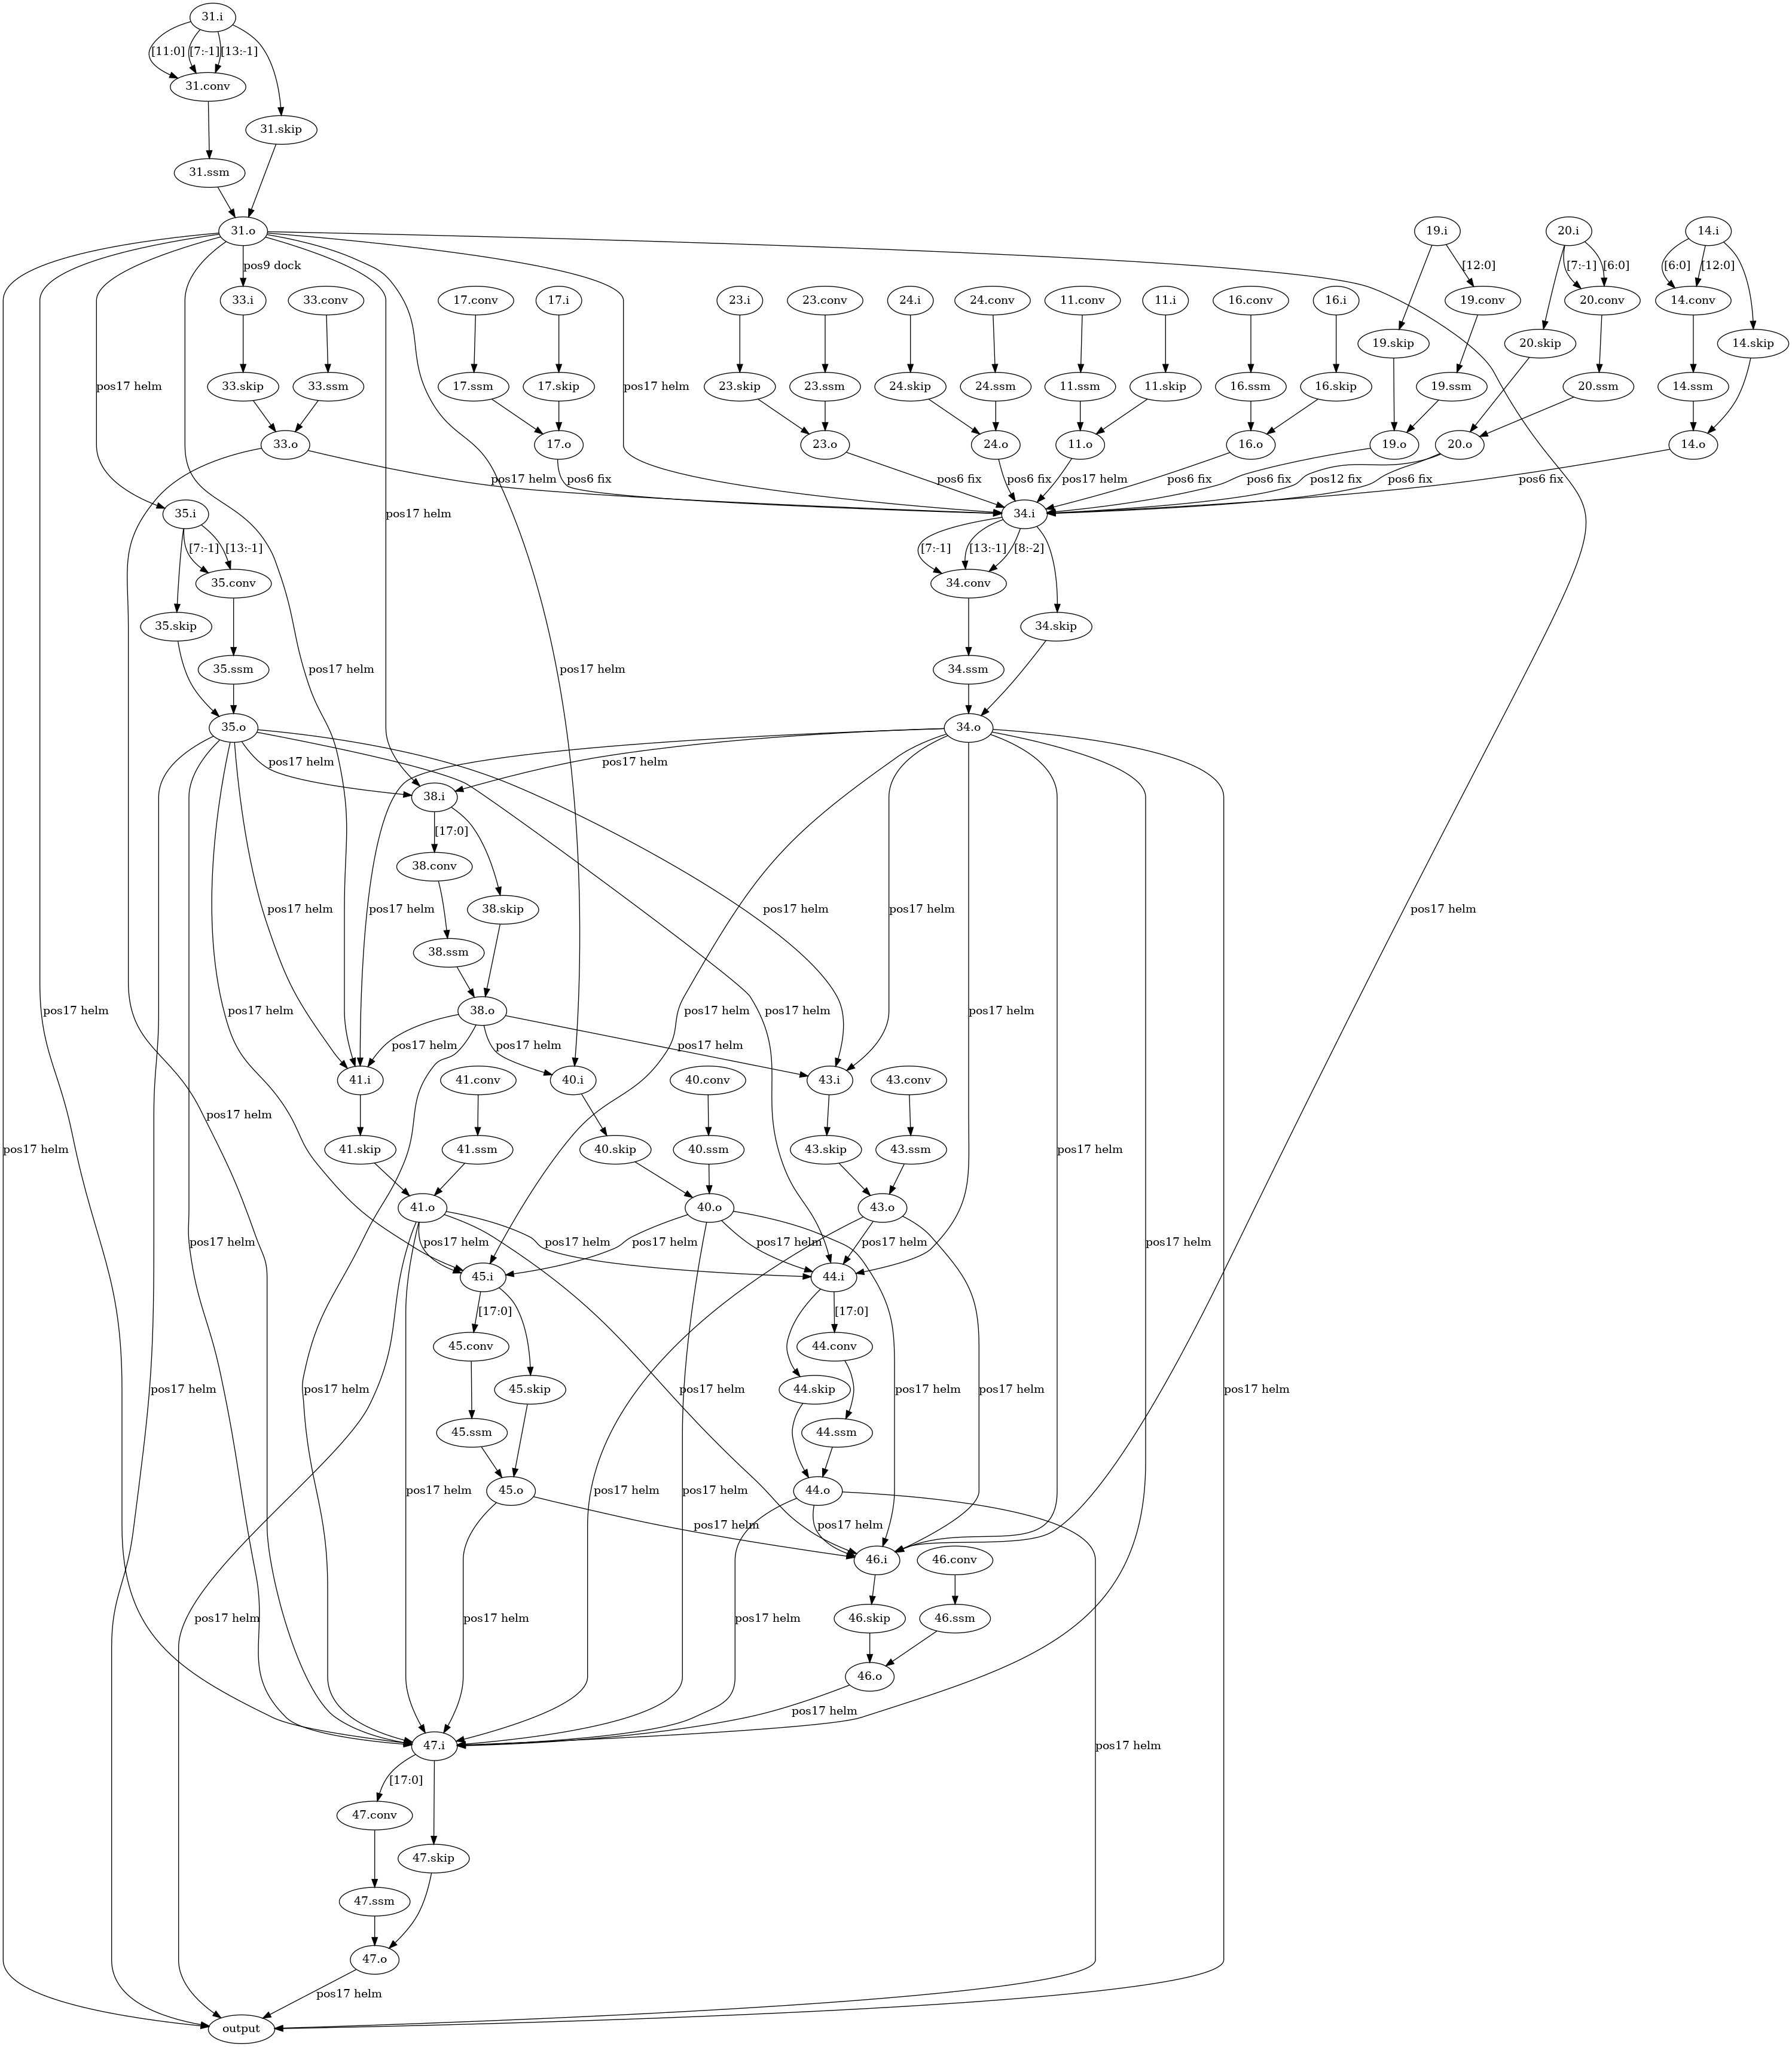

/home/dev/mamba_interp/pruned dot 0.3.png

In [94]:
position_map = {}
for l in range(L):
    position_map[l] = f'pos{l}{toks[l]}'

import graphviz
for layer in range(model.cfg.n_layers):
    layer_attrs = []
    for l in range(L):
        for filter_i in range(model.cfg.d_conv):
            filter_offset = -filter_i
            index = l*model.cfg.d_conv + filter_i
            attr = by_filters[index, layer]
            if attr < 0:
                layer_attrs.append((position_map[l+filter_offset], attr, filter_offset))
    print(layer)
    for tok, attr, filter_offset in layer_attrs:
        attr = -attr*1000
        print(f"  {tok}[{filter_offset}] {attr:.5f}")

def map_layer(layer):
    if layer == 0: return 'embed'
    if layer == model.cfg.n_layers+1: return 'output'
    else: return str(layer-1)

for layer in range(model.cfg.n_layers+2):
    layer_attrs = []
    for other_layer in range(model.cfg.n_layers+2):
        for pos in range(L):
            if pruned_adj_mat[pos, layer, other_layer] != 0:
                layer_attrs.append((position_map[pos], f"->{map_layer(other_layer)}", pruned_adj_mat[pos, layer, other_layer]))
            if pruned_adj_mat[pos, other_layer, layer] != 0:
                layer_attrs.append((position_map[pos], f"{map_layer(other_layer)}->", pruned_adj_mat[pos, other_layer, layer]))
    print(map_layer(layer))
    for tok, label, attr in layer_attrs:
        attr = -attr*1000
        print(f"  {tok} {label} {attr:.5f}")


def layer_to_i(layer):
    if layer == 'embed': return 0
    elif layer == 'output': return model.cfg.n_layers+1
    else: return int(layer)+1

forbidden = [0,1,40]
pruned_adj_mat = better_prune_edges(adj_mat)
for i in forbidden:
    pruned_adj_mat[:,i,:] = 0
    pruned_adj_mat[:,:,i] = 0
present_layers = set()
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_layers):
        if not i+1 in forbidden and not j+1 in forbidden:
            if torch.any(pruned_adj_mat[:,i+1,j+1] != 0):
                present_layers.add(i)
                present_layers.add(j)
                #print(f"present edge {i}->{j}")
print(present_layers)
pruned_dot = graphviz.Digraph('graph')
for edge in edges_to_keep:
    is_between_layers, layer_input, layer_output = between_layers_info(edge)
    if is_between_layers:
        ini, outi = layer_to_i(layer_input), layer_to_i(layer_output)
        pos = int(edge.label)
        if pruned_adj_mat[pos, ini, outi] != 0:
            if not ini in forbidden and not outi in forbidden:
                pruned_dot.edge(edge.input_node, edge.output_node, label=position_map[int(edge.label)])
    else:
        layer = int(edge.input_node.split(".")[0])
        if layer in present_layers: # don't display stuff that are disconnected
            if '.ssm' in edge.output_node or '.skip' in edge.output_node or '.skip' in edge.input_node: # don't need all these since they are all forced on
                if edge.label == 0 or edge.label == "" or edge.label is None or edge.label == "0":
                    pruned_dot.edge(edge.input_node, edge.output_node)
            else:
                pruned_dot.edge(edge.input_node, edge.output_node, label=edge.label)
output_name = f'pruned dot {ACC_THRESH}'
# too big:
from IPython.display import Image, FileLink
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

# 